In [1]:
# === Imports === #

# My imports
import os
import subprocess
import pandas as pd
from tqdm import tqdm
import shutil

# Various python packages are used in this notebook. Please get yourself used to them (optional).
import pandas as pd  # used for storing a tabular representation of the dataset, similar to XLS files.
from pathlib import Path # used to check if the saved model files and accessories.
import requests #used to request remote judge.csv evaluation 
from sklearn.preprocessing import StandardScaler  # used for normalization of dataset
from sklearn.preprocessing   import LabelBinarizer    # used for splitting the gender column
from sklearn.preprocessing   import MinMaxScaler      # used for normalization of dataset
from sklearn.model_selection import train_test_split  # used for performing the train-test split of a dataframe
import cv2                                            # OpenCV used for image processing
import random   #random number generator
import datetime #used to get current date/time
import math     #math/numerical functions
import os       #os specific functions, like file open/close etc.
import gc       #garbage collection module -- used to manually clean up memory spaces/references.


from sklearn.preprocessing import OneHotEncoder   #My favorite categorical to numerical feature conversion tool
from tensorflow import keras  # keras used for construction of the Artificial neural network
from keras.models import Sequential #keras model architectures
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten,Dropout, BatchNormalization #types of layers
from keras.losses import mean_squared_error, huber, log_cosh  #built-in loss 
from tensorflow.python.keras.saving import hdf5_format  #used for saving models 
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard  #callbacks
from keras.models import model_from_json  #used for loading model architecture from json file
import h5py  #saved model type

import matplotlib.pyplot as plt  # used for training visualization
import numpy as np  # numpy arrays used for matrix computations

# === Extra Configurations for the GPU Environment === #
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices)>0: #If you have at least one "configured" GPU, let's use it; otherwise, pass
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

import pickle 

In [4]:
"""
Setting work environment with dataset. If on Google colaboratory, we need to extract dataset stored in google drive,
otherwise the dataset is already there.
"""
try:
    from google.colab import drive
    print('Running on Google colab...')
    drive.mount('/content/drive')
    #import zipfile
    #with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/csci5931sp22/PA2-dataset/Archive.zip', 'r') as zip_ref:
    #    zip_ref.extractall('dataset/')
except:
    print('Running on local machine...')

Running on Google colab...
Mounted at /content/drive


In [5]:
folder_path = './drive/MyDrive/Colab Notebooks/DAiSEE/'

all_labels = pd.read_csv(os.path.join(folder_path, 'Labels/AllLabels.csv'))

# Find the labels for a single sample
file_extension = '.avi'
sample_num = '5000441001' + file_extension
all_labels[all_labels['ClipID']==sample_num].values.tolist()[0][-4:]

[1, 2, 0, 0]

In [ ]:
desired_img_shape = (299,224)

# The following two methods are taken from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub


def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, target_frames=10, resize=desired_img_shape, blur_background=True):
    
    if blur_background:
        cap = cv2.VideoCapture(path)
        try:
            fgbg = cv2.createBackgroundSubtractorMOG2(detectShadows=False)
            # BUILD UP MASK
            masks =[]
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.resize(frame, resize)
                frame = fgbg.apply(frame)
                masks.append(frame)
        finally:
            cap.release()   

        foreground = np.zeros((resize[1], resize[0]))
        for mask in masks:
            foreground = foreground + mask 
        foreground_mask = (foreground - np.min(foreground))/np.ptp(foreground) * 255
        
        #Try clipping instead -- did not work
        #foreground_mask = foreground.astype('uint8')

        erode_kernel = np.ones((3, 3), 'uint8')
        erode_mask = cv2.erode(foreground_mask, erode_kernel, iterations=0) # HYPERPARAMETER

        dilate_kernel = np.ones((5, 5), 'uint8')
        dilate_mask = cv2.dilate(erode_mask, dilate_kernel, iterations=10) # HYPERPARAMETER

        dilate_mask = dilate_mask.astype('uint8')
        ret, thresh_img = cv2.threshold(dilate_mask, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        bitwise_not_mask = cv2.bitwise_not(thresh_img)
        thresh_mask = np.dstack((thresh_img, thresh_img, thresh_img))

    cap = cv2.VideoCapture(path)
    frames = []
    try:

        frame_skip = cap.get(cv2.CAP_PROP_FRAME_COUNT) // target_frames
        frame_skip = int(frame_skip)
        #math.floor(cap.get(cv2.CAP_PROP_FRAME_COUNT) / target_frames)

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            #frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]] # BGR -> RGB

            if blur_background:
            # Apply background subtraction
                background_blur = cv2.GaussianBlur(frame, (25,25), 20) # Hyperparameters!!!
                background = cv2.bitwise_or(background_blur, background_blur, mask=bitwise_not_mask)

                #plt.imshow(background)

                foreground = cv2.bitwise_and(frame, thresh_mask)

                #plt.imshow(foreground)

                frame = cv2.bitwise_or(foreground, background)

            frames.append(frame)

            if len(frames) == target_frames:
                break
            else:
                for _ in range(frame_skip-1):
                    ret, frame = cap.read()
    finally:
        cap.release()

    assert len(frames) == target_frames

    return np.array(frames)

In [ ]:
sample_path = os.path.join(folder_path, 'DataSet', 'Train', '110001', '1100011002', '1100011002.avi')
print(sample_path)
#cap = cv2.VideoCapture(sample_path)

./drive/MyDrive/Colab Notebooks/DAiSEE/DataSet/Train/110001/1100011002/1100011002.avi


In [ ]:
samples = load_video(sample_path, target_frames=10, blur_background=False)

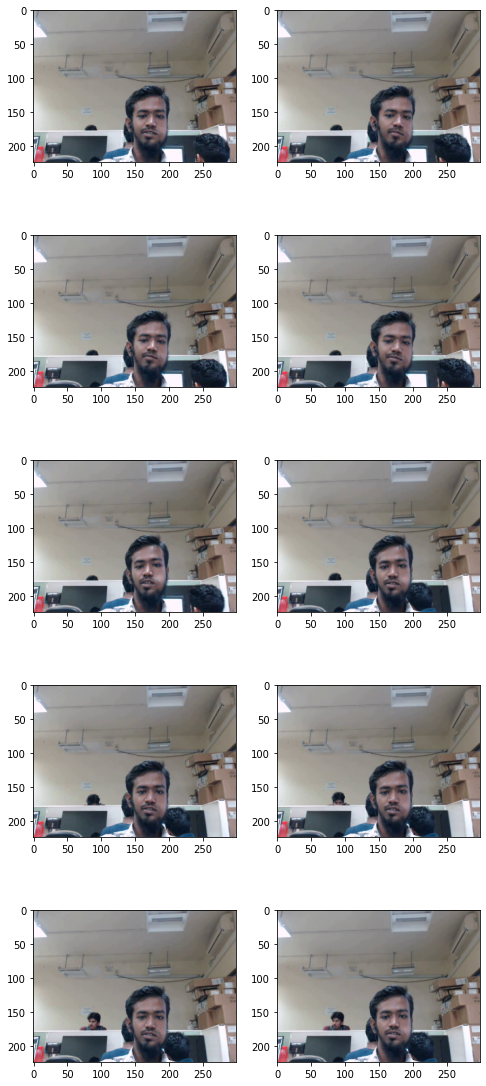

In [ ]:
desired_img_shape = (299,224)
w = 299
h = 224
fig = plt.figure(figsize=(8, 20))
columns = 2
rows = 5
for i in range(0, columns*rows):
    img = samples[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

In [ ]:
sample_destination_filename = os.path.join(folder_path, 'gen-test', '1100011002.pkl')
filehandler = open(sample_destination_filename, 'wb') 
pickle.dump(samples, filehandler)

In [ ]:
filehandler = open(sample_destination_filename, 'rb') 
loaded_sample = pickle.load(filehandler)

In [ ]:
loaded_sample.shape

(10, 224, 299, 3)

In [ ]:
subset_directory = os.path.join(folder_path, 'DataSet')
subsets = ['Train', 'Test', 'Validation']

generated_folder = 'gen-rnn-7'
resize_scale = "299:224"

SIMPLE_FLAG = False # Set to true to generate only a single video from each person

if generated_folder in os.listdir(folder_path):
    shutil.rmtree(os.path.join(folder_path, generated_folder))
os.makedirs(os.path.join(folder_path, generated_folder))
target_directory = os.path.join(folder_path, generated_folder)

for subset in subsets:
    subset_path = os.path.join(subset_directory, subset)

    os.makedirs(os.path.join(folder_path, generated_folder, subset))

    persons = os.listdir(subset_path)
    for person in tqdm(persons):
        person_path = os.path.join(subset_path, person)
        person_videos = os.listdir(person_path)
        for person_video in person_videos:
            try:

                person_video_path = os.path.join(person_path, person_video)
                
                if len(os.listdir(person_video_path)) == 0:
                    continue

                filename = os.listdir(person_video_path)[0]
                source_path = os.path.join(person_video_path, filename)
                
                new_filename = person_video + ".pkl"

                target_path = os.path.join(target_directory, subset, new_filename)

                samples = load_video(source_path, target_frames=10, blur_background=False)

                filehandler = open(target_path, 'wb') 
                pickle.dump(samples, filehandler)

            except:
                print("error with " + person_video)

            if SIMPLE_FLAG: break


100%|██████████| 22/22 [26:12<00:00, 71.47s/it]


In [ ]:
print("Success...")

Success...


https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3